<a href="https://colab.research.google.com/github/kiryu-3/Prmn2023/blob/main/Python/Python_Machine/Machine_Learning_1_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# 重回帰分析ー実践編

In [ ]:
# 最初にインポートしてください
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_openml

知識編で扱った正規方程式を使う流れを、  
**scikit-learn**というライブラリを使うことで簡略化することができます。

ここでは、アメリカのアイオワ州にあるエイムズという都市の住宅販売価格のデータセットを使用します。  
2006年から2010年のデータのようです。

Kaggleというデータコンペサイトにも同じデータセットがあります（リンクは[こちら](https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/data)）。  
別のノートブックでは分析結果をKaggleに提出してscoreを出すところまでやろうと思います。

## データの読み込み

今回は、OpenMLと呼ばれるオンラインのデータセットリポジトリからデータセットをダウンロードします。

Ames housingデータセットを取得し、DataFrameを表示しています。

In [ ]:
# Ames housing datasetを取得し、as_frame=Trueを指定してDataFrame形式で読み込む
housing = fetch_openml(name="house_prices", as_frame=True)

# DataFrameを表示
df = housing.frame

df

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,None,Reg,Lvl,AllPub,...,0,None,MnPrv,None,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,None,Reg,Lvl,AllPub,...,0,None,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,4,2010,WD,Normal,142125


1460件のデータがあり、カラムは81コもあるようです。

## データの俯瞰

ヒノマルクさんの[こちら](https://www.hinomaruc.com/ames-dataset-analytics-2/)の記事を参考にしました。

`info`メソッドで全体のデータの概要を見てみましょう。

In [ ]:
# レコード件数、カラム数、欠損値の存在、データ型の確認
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

各カラムの説明はヒノマルクさんの[こちら](https://www.hinomaruc.com/ames-dataset-analytics-1/#toc6)の記事を参照してください。

次に、各カラムの欠損割合を確認します。

In [ ]:
# 欠損値の数を計算
chk_null = df.isnull().sum()

# 欠損値の割合を計算
chk_null_pct = chk_null / (df.index.max() + 1)

# 欠損値の数と割合がゼロでない列を抽出し、欠損値テーブルを作成
chk_null_tbl = pd.concat([chk_null[chk_null > 0], chk_null_pct[chk_null_pct > 0]], axis=1)

# 欠損値の割合を基準にテーブルを降順でソートし、列名を変更
chk_null_tbl = chk_null_tbl.sort_values(by=1, ascending=False).rename(columns={0: "欠損レコード数", 1: "欠損割合"})
chk_null_tbl

,欠損レコード数,欠損割合
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageType,81,0.055479
GarageYrBlt,81,0.055479
GarageFinish,81,0.055479
GarageQual,81,0.055479


次に、数値型のカラムの記述統計量を確認します。

- オプションで指定しなければ四分位までしか出力されない。
- 欠損値とはなっていなくても、"0"ばかりのデータなどを確認することができる。
- 99パーセンタイルと最大値を見ることで、異常値が確認しやすくなる。

In [ ]:
# 記述統計量を確認(カラム数が多いので縦持ちに変換)
df.describe(percentiles=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.95,0.99]).transpose()

,count,mean,std,min,10%,20%,30%,40%,50%,60%,70%,80%,90%,95%,99%,max
Id,1460.0,730.500000,421.610009,1.0,146.9,292.8,438.7,584.6,730.5,876.4,1022.3,1168.2,1314.1,1387.05,1445.41,1460.0
MSSubClass,1460.0,56.897260,42.300571,20.0,20.0,20.0,20.0,30.0,50.0,60.0,60.0,80.0,120.0,160.00,190.00,190.0
LotFrontage,1201.0,70.049958,24.284752,21.0,44.0,53.0,60.0,63.0,69.0,74.0,79.0,85.0,96.0,107.00,141.00,313.0
LotArea,1460.0,10516.828082,9981.264932,1300.0,5000.0,7078.4,8063.7,8793.4,9478.5,10198.2,11066.5,12205.8,14381.7,17401.15,37567.64,215245.0
OverallQual,1460.0,6.099315,1.382997,1.0,5.0,5.0,5.0,6.0,6.0,6.0,7.0,7.0,8.0,8.00,10.00,10.0
OverallCond,1460.0,5.575342,1.112799,1.0,5.0,5.0,5.0,5.0,5.0,5.0,6.0,7.0,7.0,8.00,9.00,9.0
YearBuilt,1460.0,1971.267808,30.202904,1872.0,1924.9,1947.8,1958.0,1965.0,1973.0,1984.0,1997.3,2003.0,2006.0,2007.00,2009.00,2010.0
YearRemodAdd,1460.0,1984.865753,20.645407,1950.0,1950.0,1961.8,1971.0,1980.0,1994.0,1998.0,2002.0,2005.0,2006.0,2007.00,2009.00,2010.0
MasVnrArea,1452.0,103.685262,181.066207,0.0,0.0,0.0,0.0,0.0,0.0,16.0,117.0,206.0,335.0,456.00,791.92,1600.0
BsmtFinSF1,1460.0,443.639726,456.098091,0.0,0.0,0.0,0.0,218.6,383.5,525.6,655.0,806.4,1065.5,1274.00,1572.41,5644.0


次に、名義型のカラムの記述統計量を確認します。

- レコード数、ユニーク数、最頻値、最頻値の出現数を確認できる。

In [ ]:
# 名義型の変数の統計量を確認
df.describe(include=['O']).transpose()

,count,unique,top,freq
MSZoning,1460,5,RL,1151
Street,1460,2,Pave,1454
Alley,91,2,Grvl,50
LotShape,1460,4,Reg,925
LandContour,1460,4,Lvl,1311
Utilities,1460,2,AllPub,1459
LotConfig,1460,5,Inside,1052
LandSlope,1460,3,Gtl,1382
Neighborhood,1460,25,NAmes,225
Condition1,1460,9,Norm,1260


データをグラフで俯瞰することもできます。  
ヒノマルクさんの[こちら](https://shorturl.at/jrY58)の記事を参照してください。

## 欠損値処理

改めて欠損値について確認してみましょう。

In [ ]:
chk_null_tbl

,欠損レコード数,欠損割合
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageType,81,0.055479
GarageYrBlt,81,0.055479
GarageFinish,81,0.055479
GarageQual,81,0.055479


### 欠損値に意味がある場合

欠損値は中央値や最頻値で埋めてもいいのですが、欠損値に意味がある場合の考慮が必要です。  
（そもそも該当の施設が存在しない、など）

今回はそんなカラムを指定し、"NA"という区分で値を埋めることにします。

In [ ]:
"""
下記カラムは欠損値に意味がある(施設がそもそもないなど)ので、
欠損を意味する"NA"というカテゴリにします
"""

columns = [
    "PoolQC",
    "MiscFeature",
    "Alley",
    "Fence",
    "FireplaceQu",
    "GarageFinish",
    "GarageQual",
    "GarageCond",
    "GarageYrBlt",
    "GarageType",
    "BsmtExposure",
    "BsmtCond",
    "BsmtQual",
    "BsmtFinType2",
    "BsmtFinType1"
]

df[columns].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PoolQC        7 non-null      object 
 1   MiscFeature   54 non-null     object 
 2   Alley         91 non-null     object 
 3   Fence         281 non-null    object 
 4   FireplaceQu   770 non-null    object 
 5   GarageFinish  1379 non-null   object 
 6   GarageQual    1379 non-null   object 
 7   GarageCond    1379 non-null   object 
 8   GarageYrBlt   1379 non-null   float64
 9   GarageType    1379 non-null   object 
 10  BsmtExposure  1422 non-null   object 
 11  BsmtCond      1423 non-null   object 
 12  BsmtQual      1423 non-null   object 
 13  BsmtFinType2  1422 non-null   object 
 14  BsmtFinType1  1423 non-null   object 
dtypes: float64(1), object(14)
memory usage: 171.2+ KB


In [ ]:
df["PoolQC"] = df["PoolQC"].fillna("NA")
df["MiscFeature"] = df["MiscFeature"].fillna("NA")
df["Alley"] = df["Alley"].fillna("NA")
df["Fence"] = df["Fence"].fillna("NA")
df["FireplaceQu"] = df["FireplaceQu"].fillna("NA")
df["GarageFinish"] = df["GarageFinish"].fillna("NA")
df["GarageQual"] = df["GarageQual"].fillna("NA")
df["GarageCond"] = df["GarageCond"].fillna("NA")
df["GarageYrBlt"] = df["GarageYrBlt"].fillna(0)
df["GarageType"] = df["GarageType"].fillna("NA")
df["BsmtExposure"] = df["BsmtExposure"].fillna("NA")
df["BsmtCond"] = df["BsmtCond"].fillna("NA")
df["BsmtQual"] = df["BsmtQual"].fillna("NA")
df["BsmtFinType2"] = df["BsmtFinType2"].fillna("NA")
df["BsmtFinType1"] = df["BsmtFinType1"].fillna("NA")

欠損値が埋まったことを確認します。

In [ ]:
columns = [
    "PoolQC",
    "MiscFeature",
    "Alley",
    "Fence",
    "FireplaceQu",
    "GarageFinish",
    "GarageQual",
    "GarageCond",
    "GarageYrBlt",
    "GarageType",
    "BsmtExposure",
    "BsmtCond",
    "BsmtQual",
    "BsmtFinType2",
    "BsmtFinType1"
]

df[columns].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PoolQC        1460 non-null   object 
 1   MiscFeature   1460 non-null   object 
 2   Alley         1460 non-null   object 
 3   Fence         1460 non-null   object 
 4   FireplaceQu   1460 non-null   object 
 5   GarageFinish  1460 non-null   object 
 6   GarageQual    1460 non-null   object 
 7   GarageCond    1460 non-null   object 
 8   GarageYrBlt   1460 non-null   float64
 9   GarageType    1460 non-null   object 
 10  BsmtExposure  1460 non-null   object 
 11  BsmtCond      1460 non-null   object 
 12  BsmtQual      1460 non-null   object 
 13  BsmtFinType2  1460 non-null   object 
 14  BsmtFinType1  1460 non-null   object 
dtypes: float64(1), object(14)
memory usage: 171.2+ KB


### groupby後に欠損値処理

"間口距離"を意味するLotFrontageカラムの値は、同じ地区の中央値の値で埋めてあげると良いようです。

In [ ]:
# "LotFrontage"の欠損値が存在する行のインデックスを取得する
lotfrontage_na_idx = df[df["LotFrontage"].isna()].index

# "LotFrontage"カラムの値がすべて"NaN"のデータフレーム
df.iloc[lotfrontage_na_idx]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
7,8,60,RL,NaN,10382,Pave,NA,IR1,Lvl,AllPub,...,0,NA,NA,Shed,350,11,2009,WD,Normal,200000
12,13,20,RL,NaN,12968,Pave,NA,IR2,Lvl,AllPub,...,0,NA,NA,NA,0,9,2008,WD,Normal,144000
14,15,20,RL,NaN,10920,Pave,NA,IR1,Lvl,AllPub,...,0,NA,GdWo,NA,0,5,2008,WD,Normal,157000
16,17,20,RL,NaN,11241,Pave,NA,IR1,Lvl,AllPub,...,0,NA,NA,Shed,700,3,2010,WD,Normal,149000
24,25,20,RL,NaN,8246,Pave,NA,IR1,Lvl,AllPub,...,0,NA,MnPrv,NA,0,5,2010,WD,Normal,154000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1429,1430,20,RL,NaN,12546,Pave,NA,IR1,Lvl,AllPub,...,0,NA,NA,NA,0,4,2007,WD,Normal,182900
1431,1432,120,RL,NaN,4928,Pave,NA,IR1,Lvl,AllPub,...,0,NA,NA,NA,0,10,2009,WD,Normal,143750
1441,1442,120,RM,NaN,4426,Pave,NA,Reg,Lvl,AllPub,...,0,NA,NA,NA,0,5,2008,WD,Normal,149300
1443,1444,30,RL,NaN,8854,Pave,NA,Reg,Lvl,AllPub,...,0,NA,NA,NA,0,5,2009,WD,Normal,121000


In [ ]:
# NeighbourhoodごとにLotFrontageの中央値を算出
platform_neighbourhood_dict = df.groupby("Neighborhood").median()["LotFrontage"].to_dict()
platform_neighbourhood_dict

<ipython-input-12-49c946ba02cb>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  platform_neighbourhood_dict = df.groupby("Neighborhood").median()["LotFrontage"].to_dict()


{'Blmngtn': 43.0,
 'Blueste': 24.0,
 'BrDale': 21.0,
 'BrkSide': 52.0,
 'ClearCr': 80.0,
 'CollgCr': 70.0,
 'Crawfor': 74.0,
 'Edwards': 65.5,
 'Gilbert': 65.0,
 'IDOTRR': 60.0,
 'MeadowV': 21.0,
 'Mitchel': 73.0,
 'NAmes': 73.0,
 'NPkVill': 24.0,
 'NWAmes': 80.0,
 'NoRidge': 91.0,
 'NridgHt': 88.5,
 'OldTown': 60.0,
 'SWISU': 60.0,
 'Sawyer': 71.0,
 'SawyerW': 66.5,
 'Somerst': 73.5,
 'StoneBr': 61.5,
 'Timber': 85.0,
 'Veenker': 68.0}

In [ ]:
df["LotFrontage"] = df.apply(
    lambda row: platform_neighbourhood_dict[row["Neighborhood"]]
    if np.isnan(row["LotFrontage"])
    else row["LotFrontage"],
    axis=1
)

In [ ]:
# "LotFrontage"カラムの値がすべて"NaN"だったデータフレーム
# 同じ地区の中央値の値で欠損値を埋めている
df.iloc[lotfrontage_na_idx]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
7,8,60,RL,80.0,10382,Pave,NA,IR1,Lvl,AllPub,...,0,NA,NA,Shed,350,11,2009,WD,Normal,200000
12,13,20,RL,71.0,12968,Pave,NA,IR2,Lvl,AllPub,...,0,NA,NA,NA,0,9,2008,WD,Normal,144000
14,15,20,RL,73.0,10920,Pave,NA,IR1,Lvl,AllPub,...,0,NA,GdWo,NA,0,5,2008,WD,Normal,157000
16,17,20,RL,73.0,11241,Pave,NA,IR1,Lvl,AllPub,...,0,NA,NA,Shed,700,3,2010,WD,Normal,149000
24,25,20,RL,71.0,8246,Pave,NA,IR1,Lvl,AllPub,...,0,NA,MnPrv,NA,0,5,2010,WD,Normal,154000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1429,1430,20,RL,80.0,12546,Pave,NA,IR1,Lvl,AllPub,...,0,NA,NA,NA,0,4,2007,WD,Normal,182900
1431,1432,120,RL,24.0,4928,Pave,NA,IR1,Lvl,AllPub,...,0,NA,NA,NA,0,10,2009,WD,Normal,143750
1441,1442,120,RM,70.0,4426,Pave,NA,Reg,Lvl,AllPub,...,0,NA,NA,NA,0,5,2008,WD,Normal,149300
1443,1444,30,RL,52.0,8854,Pave,NA,Reg,Lvl,AllPub,...,0,NA,NA,NA,0,5,2009,WD,Normal,121000


### 中央値と最頻値で欠損値処理

ここまでの処理結果を確認します。

In [ ]:
# 欠損値の数を計算
chk_null2 = df.isnull().sum()

# 欠損値の割合を計算
chk_null_pct2 = chk_null2 / (df.index.max() + 1)

# 欠損値の数と割合がゼロでない列を抽出し、欠損値テーブルを作成
chk_null_tbl2 = pd.concat([chk_null2[chk_null2 > 0], chk_null_pct2[chk_null_pct2 > 0]], axis=1)

# 欠損値の割合を基準にテーブルを降順でソートし、列名を変更
chk_null_tbl_new = chk_null_tbl2.sort_values(by=1, ascending=False).rename(columns={0: "欠損レコード数", 1: "欠損割合"})
chk_null_tbl_new

,欠損レコード数,欠損割合
MasVnrType,8,0.005479
MasVnrArea,8,0.005479
Electrical,1,0.000685


残りのカラムは、数値型のカラムのデータは中央値で、  
名義型のカラムのデータは最頻値で埋めます。

In [ ]:
"""
"MasVnrArea	"カラム（組積造の面積）は
数値型なので中央値で欠損値処理
"MasVnrType"カラム（組積造の種別）と"Electrical"カラム（電気システムの種類）は
名義型なので最頻値で欠損値処理
"""

# 欠損値の数を計算し、0以外のカラムのインデックスを抽出
nonzero_columns = chk_null_tbl_new.index

# 欠損値を埋める処理
for column in nonzero_columns:
    if np.issubdtype(df[column].dtype, np.number):
        # 数値型の場合は中央値で埋める
        df[column].fillna(df[column].median(), inplace=True)
    else:
        # 文字型の場合は最頻値で埋める
        df[column].fillna(df[column].mode()[0], inplace=True)

In [ ]:
# 欠損値の数を計算
chk_null3 = df.isnull().sum()

# 欠損値の割合を計算
chk_null_pct3 = chk_null3 / (df.index.max() + 1)

# 欠損値の数と割合がゼロでない列を抽出し、欠損値テーブルを作成
chk_null_tbl3 = pd.concat([chk_null3[chk_null3 > 0], chk_null_pct3[chk_null_pct3 > 0]], axis=1)

# 欠損値の割合を基準にテーブルを降順でソートし、列名を変更
chk_null_tbl_end = chk_null_tbl3.sort_values(by=1, ascending=False).rename(columns={0: "欠損レコード数", 1: "欠損割合"})
chk_null_tbl_end

,欠損レコード数,欠損割合


すべての欠損値を埋めることができました。

## そのほかのデータの加工

ヒノマルクさんの記事群(リンクは[こちら](https://www.hinomaruc.com/tag/ames/?order=asc))にもありますが、  
ほかにも以下のような加工をすることで、モデルの精度向上が期待できます。



- 外れ値処理

  - 外れ値かどうかを判断して除外するかどうかを検討する。

- 特徴量エンジニアリング

  - 新しい意味を持つ変数を作成する。
  - より説明力がある変数が作成できたり、変数の数を減らせる可能性がある。
  
- 変数選択

  - モデリングに必要なさそうな変数は除外する。
  - 計算量を減らせたり多重共線性を防げる可能性がある。

ヒノマルクさんの[こちら](https://www.hinomaruc.com/ames-dataset-analytics-3-1/)の記事を参考にしました。

## 住宅価格を重回帰分析で予測

いよいよ住宅価格の予測に入ります。

### データ型の変換

まず初めに、データ型を適切なタイプに変換します。

以下カラムは数値型になっていますが、その数値の**大きさ**には意味がなさそうなので  
カテゴリ型に変換します。



In [ ]:
df['YrSold'] = df['YrSold'].astype(str)  # 売れた年
df['MoSold'] = df['MoSold'].astype(str)  # 売れた月
df['GarageYrBlt'] = df['GarageYrBlt'].astype(str)  # ガレージが建てられた年
df['YearBuilt'] = df['YearBuilt'].astype(str)  # 建築された年
df['YearRemodAdd'] = df['YearRemodAdd'].astype(str)  # リフォームされた年
df['MSSubClass'] = df['MSSubClass'].astype(str)  # 建物クラス（建てられ方の違い）

### 変数の選択

"SalePrice"カラム（住宅価格）とほかのカラムの相関係数を求めます。

相関係数が高かったカラムを重回帰分析に使うカラムとして採用します。

In [ ]:
# 相関行列の計算
correlation = df.corr()

# SalePriceとの相関係数の降順にソート
price_corr = correlation['SalePrice'].sort_values(ascending=False)

# 相関係数の表示
pd.DataFrame(price_corr).head(10)

<ipython-input-19-4f591516d47d>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation = df.corr()


,SalePrice
SalePrice,1.000000
OverallQual,0.790982
GrLivArea,0.708624
GarageCars,0.640409
GarageArea,0.623431
TotalBsmtSF,0.613581
1stFlrSF,0.605852
FullBath,0.560664
TotRmsAbvGrd,0.533723
MasVnrArea,0.472614


ここでは、相関係数の高かった以下の10つのカラムを  
**説明変数**として採用することにします。

In [ ]:
# "SalePrice"と相関係数の高かったカラム
columns = [
    "SalePrice",  # 住宅価格
    "OverallQual",  #  住居の品質
    "GrLivArea",  # 地上全ての住宅面積
    "GarageCars",  # ガレージへの駐車可能台数
    "GarageArea",  # 地上全ての住宅面積（地下室は除く）
    "TotalBsmtSF",  # 全地下室の面積
    "1stFlrSF",  # 1Fの面積
    "FullBath",  # フル・バスルームの数（地下室は除く）
    "TotRmsAbvGrd",  # 総部屋数 (バスルーム、地下室は除く))
    "MasVnrArea"  # 組積造の面積(ft2)
]

new_df = df[columns]

では、相関表のヒートマップを見てみましょう。

<Axes: >

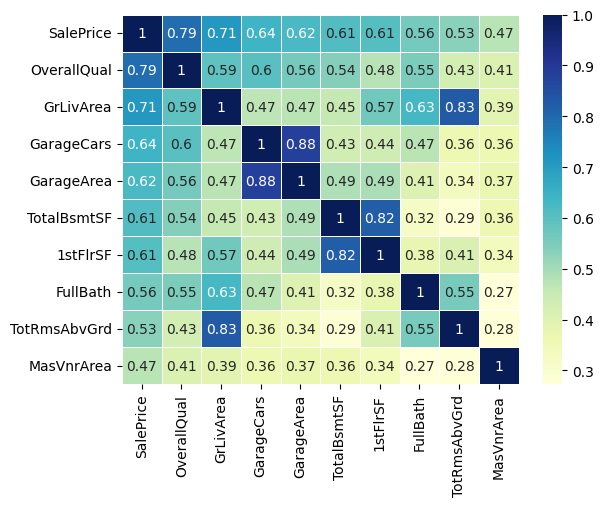

In [ ]:
sns.heatmap(new_df.corr(), annot=True, cmap='YlGnBu', linewidths=0.5)

ヒートマップを見ると、以下説明変数間の相関係数が高くなってしまっていることが分かります。

- GrLivAreaカラムとTotRmsAbvGrdカラム
- GarageCarsカラムとGarageAreaカラム
- TotalBsmtSFカラムと1stFlrSFカラム

**多重共線性**とは、複数の説明変数間に高い相関が存在することです。  
この現象により、重回帰分析において説明変数の効果が正しく評価されにくくなることがあります。

相関が高い説明変数同士が重なり合うことで、各説明変数の重要度が明確に特定できず、  
統計的な解釈や予測性能の信頼性が低下します。

ここで、相関が高くなってしまっている説明変数のペアのうち、  
目的変数"SalePrice"との相関がより高い説明変数を残すことにします。


In [ ]:
selected_columns = [
    "SalePrice",  # 住宅価格
    "OverallQual",  #  住居の品質
    "GrLivArea",  # 地上全ての住宅面積
    "GarageCars",  # ガレージへの駐車可能台数
    "TotalBsmtSF",  # 全地下室の面積
    "FullBath",  # フル・バスルームの数（地下室は除く）
    "MasVnrArea"  # 組積造の面積(ft2)
]

new_df = df[selected_columns]

では、相関表のヒートマップを見てみましょう。

<Axes: >

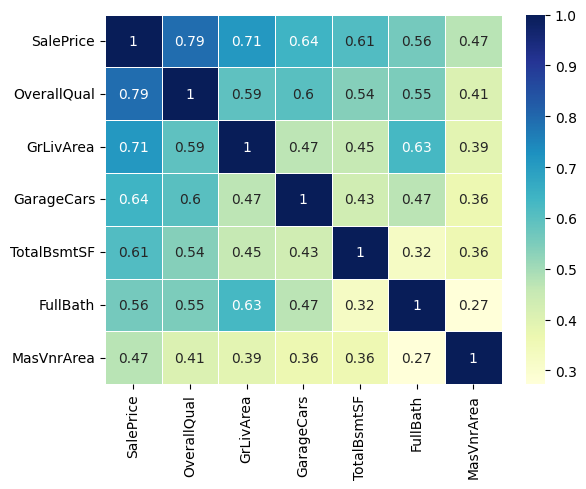

In [ ]:
sns.heatmap(new_df.corr(), annot=True, cmap='YlGnBu', linewidths=0.5)

### 汎化性能

学習データだけでなく未知のデータに対しても正しく予測できる性能のことを、  
**汎化性能**といいます。

汎化性能が高いモデルは、**過学習**が起きにくくなります。

これらの事項のことは、[カメさんの記事](https://datawokagaku.com/holdout/#i)が参考になります。

### hold-out法

手元にあるデータセットを学習用とテスト用の二つに分ける手法を**hold-out法**といいます。

**学習データ**のみでモデルを構築し、  
**テストデータ**（未知のデータとする）で汎化性能を測ります。

ここでは登場していない**検証データ**は、モデルのパラメータの調整に使われます。

テストデータはあくまでも最終的な精度を測るためのものとし、途中の精度の評価は検証データに任せることで、  
過学習を抑えることができます。

これらの事項のことは、[カメさんの記事](https://datawokagaku.com/holdout/#1_hold-out)が参考になります。

### Pythonで重回帰分析

ここでは検証データを含む3分割ではなく、2分割にして学習を行います。

In [ ]:
# 必要なライブラリのインポート
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

# 目的変数に"SalePrice"、説明変数にそれ以外の6つのカラムを指定
x = new_df.drop('SalePrice', axis=1)
y = new_df['SalePrice']

# データを訓練データとテストデータに分ける
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)

# 説明変数のデータを標準化
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(x_train)
x_train_scaled = scaler.transform(x_train)

# モデルの初期化と学習
model = LinearRegression()
model.fit(x_train_scaled, y_train)

LinearRegression()

- `train_test_split`関数を使ってhold-outで分割する。
- `test_size`にテストデータの割合を入れる。5:5や7:3とすることが多い。
- `random_state`で乱数のタネを指定する。シャッフルおよび今回の分割を再現できるようになる。



In [ ]:
pd.DataFrame(x_train_scaled, columns=x.columns)

,OverallQual,GrLivArea,GarageCars,TotalBsmtSF,FullBath,MasVnrArea
0,0.678402,0.988996,0.321398,0.004040,0.782582,2.593218
1,-0.058396,-0.446594,0.321398,0.574723,-1.064529,-0.568617
2,-0.795194,-1.283217,-2.404485,-0.481285,-1.064529,-0.568617
3,-0.058396,-0.510355,-1.041544,-1.208053,-1.064529,-0.568617
4,-3.005590,-2.094722,-1.041544,-1.866533,-1.064529,-0.568617
...,...,...,...,...,...,...
1017,1.415201,1.628539,1.684340,0.479610,0.782582,3.145021
1018,-1.531993,-0.879397,0.321398,0.028428,0.782582,-0.568617
1019,-0.058396,0.733952,0.321398,-2.573791,0.782582,-0.568617
1020,0.678402,0.067359,0.321398,0.777145,0.782582,-0.469292


最後に、パラメータを確認します。

In [ ]:
# intercept  切片
print(model.intercept_)

180586.22896281802


In [ ]:
# coefficient  係数
print(pd.Series(model.coef_, index=x.columns))

OverallQual    28134.097008
GrLivArea      24993.926834
GarageCars     11595.440645
TotalBsmtSF    16498.228749
FullBath         440.926574
MasVnrArea      6858.550222
dtype: float64


### テストデータで予測

実際住宅価格を予測できているのか、テストデータを使って確かめます。


In [ ]:
# 学習データの平均と標準偏差を使って標準化する
x_test_scaled = scaler.transform(x_test)

# テストデータの一番上のデータを取得
sample_data = x_test_scaled[0]

# 住宅価格の予測
predicted_price = model.predict(sample_data.reshape(1, -1))

# 予測結果の表示
print("実際の住宅価格:", y_test.iloc[0])
print("予測された住宅価格:", predicted_price[0])

実際の住宅価格: 200624
予測された住宅価格: 267294.7278978763


In [ ]:
# テストデータの一番下のデータを取得
sample_data = x_test_scaled[-1]

# 住宅価格の予測
predicted_price = model.predict(sample_data.reshape(1, -1))

# 予測結果の表示
print("実際の住宅価格:", y_test.iloc[-1])
print("予測された住宅価格:", predicted_price[-1])

実際の住宅価格: 611657
予測された住宅価格: 377811.9887928369


そんなに予測できている感じはしないですね。

### 決定係数

「説明変数がどれだけ目的変数の値を説明しているかの指標」を**決定係数**といいます。

一般的に$R^2$で示され、0から1までの値をとります。  
1に近いほど、回帰式が実際のデータに当てはまっていることを表しています。

基準の目安は以下の通りです。  
（参考：https://istat.co.jp/ta_commentary/multiple_02 ）

* **0.8以上**：精度良い
* **0.5~0.8**：精度やや良い
* **0.5以下**：精度良くない


#### 決定係数の定義

![リンクテキスト](https://imgur.com/gsoWMOU.png)

①：全変動：実測値とデータ全体の平均値との差  
②：回帰変動：予測値とデータ全体の平均値との差  
③：残差変動：実測値と予測値との差

②の回帰変動は「回帰直線によって説明できた部分」、  
③の残差変動は「回帰直線によって説明できなかった部分」となります。

（[こちら](https://bit.ly/3XZs1IQ)などに書かれている証明によって）以下の式が成り立ちます。

$$
\sum (y_i-\bar{y})^2 = \sum(\hat{y}_i-\bar{y})^2 + \sum(y_i-\hat{y}_i)^2
$$



決定係数は「回帰変動が全変動に対してどれだけ多いか」を表すものなので、  
決定係数は回帰変動を全変動で割ることで求められます。

$$
R^2 = \frac{\sum(\hat{y}_i-\bar{y})^2}{\sum (y_i-\bar{y})^2} = 1-\frac{\sum(y_i-\hat{y}_i)^2}{\sum (y_i-\bar{y})^2}
$$

### 回帰モデルの評価指標

決定係数のほかにも回帰モデルの評価指標はあります。  
[カメさんの記事](https://datawokagaku.com/reg_metrics/)を参考にしてください。

ここでは決定係数でこのモデルを評価します。

In [ ]:
print('訓練データに対する決定係数：', model.score(x_train_scaled, y_train))
print('テストデータに対する決定係数：', model.score(x_test_scaled, y_test))

訓練データに対する決定係数： 0.7888886576143761
テストデータに対する決定係数： 0.7057924885182993


精度は"ややいい"程度のようですね。